# 历史旱涝数据说明



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

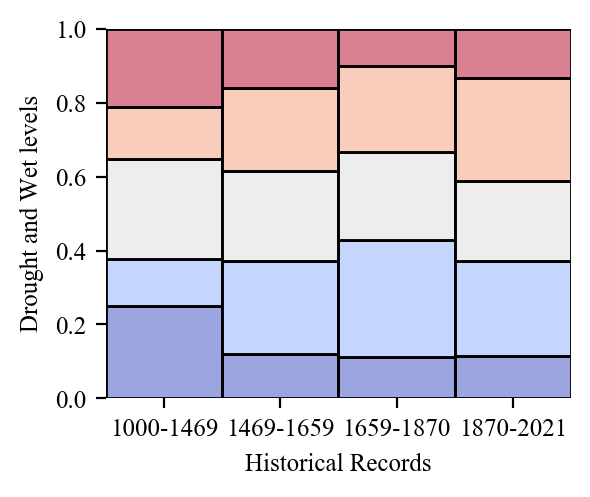

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from past1000.data import HistoricalRecords
from mksci_font import config_font
from past1000.constants import LABELS, STAGES_BINS

palette = plt.get_cmap("coolwarm").reversed()

config_font({"font.size": 9})

# The commented out code is creating an instance of the `HistoricalRecords` class from the `past1000.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)

long_form = history.data.melt(ignore_index=False).reset_index().dropna()

for i, bin in enumerate(STAGES_BINS):
    long_form["stage"] = pd.cut(long_form["year"], bins=STAGES_BINS, labels=LABELS)

fig, ax = plt.subplots(figsize=(3, 2.4))
sns.histplot(
    x="stage",
    hue="value",
    data=long_form,
    multiple="fill",
    stat="count",
    common_norm=True,
    palette=palette,
    ax=ax,
    legend=False,
    alpha=0.5,
)
sns.despine(ax=ax, left=True, bottom=True, trim=True, offset=10)
ax.set_ylabel("Drought and Wet levels")
ax.set_xlabel("Historical Records")

history.to_series(inplace=True, interpolate=None, name="historical_mean", how="mode")
plt.show();

千年之间有记录的年份

# 对比重建数据和历史数据

- 历史数据来自《中国千年旱涝图集》
- 重建数据来自 NOAA 的树轮重建数据


Millennial-scale data reveals collective memory of extreme events The impact of extreme weather events such as droughts and floods is intensifying, one important reason being that society quickly forgets past disasters and develops in disaster-prone areas. This collective memory of disasters has significantly affected a society's vulnerability to them. Still, there has long been a lack of data-driven measurements on how long this collective memory lasts. For the first time, we compared historical records with natural reconstructions over a millennium scale in China's Yellow River Basin, demonstrating that the collective memory of extreme climate lasts about 30 years (two generations). The current Earth System Models (ESMs), however, can not have sufficient spatial and temporal resolution to match this pattern, failing to capture the interactions between humans and extreme events. This finding emphasised the necessity of coupling environmental changes with human social systems and improving ESMs for the deep root of the Anthropocene.

## NOAA 树轮重建数据

In [4]:
from past1000.data import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,xu2023-asm,qinling2016precip,north-china-temp-precip2011,hexi2019scpdsi
year,,,,,,,
2009,NaN,NaN,NaN,-1.466621,-0.568723,NaN,-0.809462
2010,NaN,NaN,NaN,1.170888,0.307108,NaN,0.515620
2011,NaN,NaN,NaN,1.248765,NaN,NaN,-1.255668
2012,NaN,NaN,NaN,-1.204711,NaN,NaN,NaN
2013,NaN,NaN,NaN,0.140132,NaN,NaN,NaN


In [5]:
from past1000.mc import combine_reconstructions, plot_combined_reconstruction
from mksci_font import config_font

combined, trace = combine_reconstructions(datasets, uncertainties)
combined.head()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.472,0.450,-1.355,0.313
1001,-0.070,0.477,-0.950,0.815
1002,0.127,0.546,-0.836,1.198
1003,-0.302,0.661,-1.525,0.932
1004,-0.910,0.642,-2.062,0.320


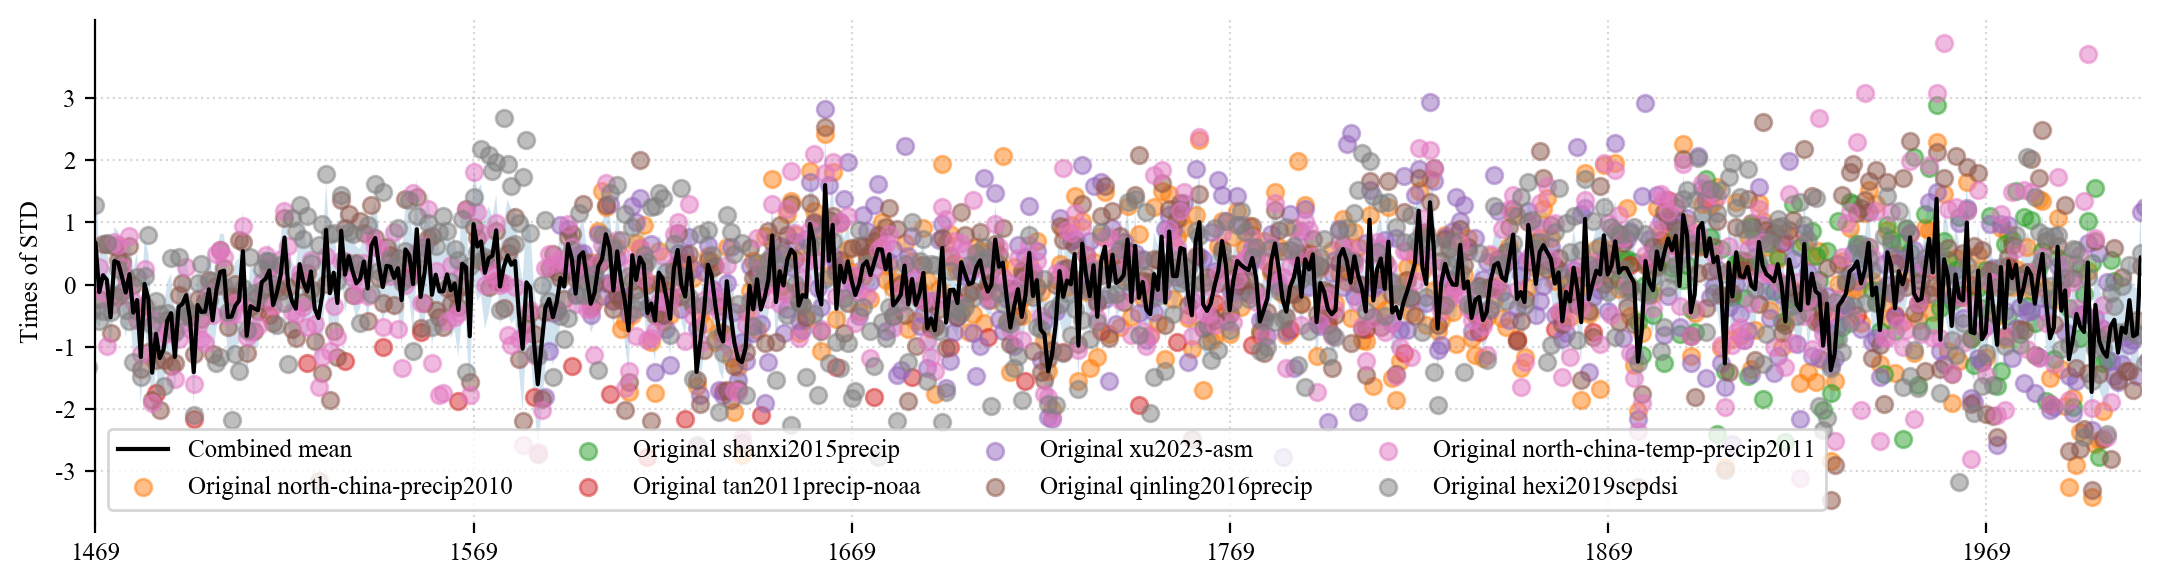

In [6]:
df = history.merge_with(combined, time_range=np.arange(1000, 2000))

ax = plot_combined_reconstruction(combined=combined, data=datasets)
# history.plot(ax=ax, color="red", ls=":", label="Historical Mean")
ax.set_ylabel("Times of STD")
ax.legend(ncol=4, loc="lower left", fontsize=9)
ax.set_xlim(1469, 2010)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.grid(True, alpha=0.3, ls=":", color="gray")
ax.set_xticks(np.arange(1469, 2010, 100))
ax.set_yticks(np.arange(-3, 3.1, 1))
plt.show();

## 历史数据的读取

历史记录与滑动平均后的树轮进行比较

## 双尾滑动

/Users/songshgeo/Documents/VSCode/past1000/past1000/data.py:320: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  result = result.interpolate(method=interpolate, **kwargs)


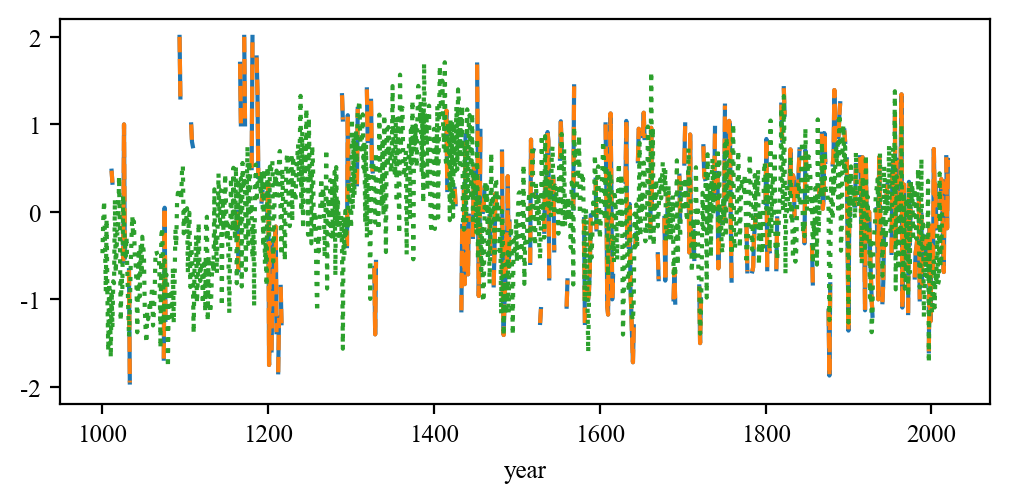

In [7]:
from past1000.utils.calc import detrend_with_nan
import matplotlib.pyplot as plt
from past1000.filters import classify

AGG_METHOD = "mean"

history_mean = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)
mode = history_mean.to_series(how=AGG_METHOD)
mode_interpolated = history_mean.to_series(how=AGG_METHOD, interpolate="linear")

detrend_mode = detrend_with_nan(mode)
detrend_mode_interpolated = detrend_with_nan(mode_interpolated)
NATURAL_RECORDS = combined["mean"]
DETREND_N = detrend_with_nan(NATURAL_RECORDS)

_, ax = plt.subplots(figsize=(6, 2.5))
mode.plot(ax=ax)
mode_interpolated.plot(ax=ax, linestyle="--")
NATURAL_RECORDS.plot(ax=ax, linestyle=":")
plt.show();

我们在中国北方选取了1000-2000年的历史数据，并将其与树轮重建数据进行了对比。我们发现，树轮重建数据与历史数据的相关性在以窗口大小为33到40年之间达到较高水平。

这说明，历史记载倾向于以30年左右的时间尺度感知气候变化。

这里我们还可以用一张综合图来说明情况。

由于一般需要5个样本，计算标准差才有意义，所以我们的 `min_periods` 参数比 `windows` 至少要小 5。













此次实验用的数据是未经过去趋势处理的.
此次实验用的相关性方法是kendall.


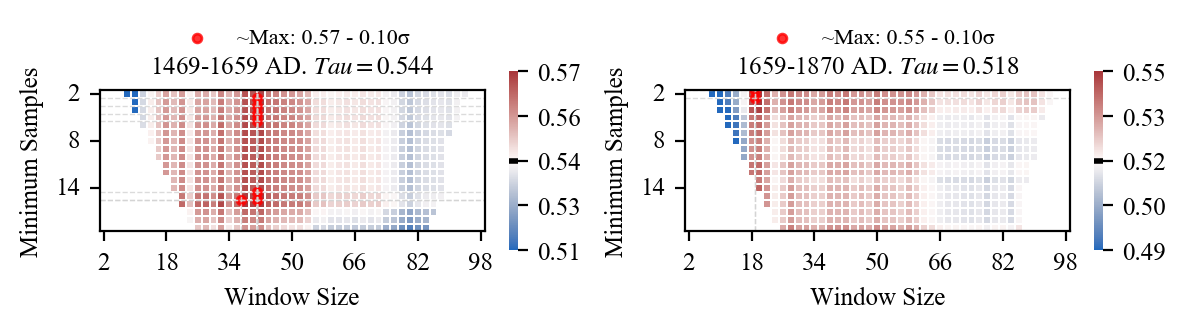

In [8]:
from past1000.compare import experiment_corr_2d
import matplotlib.pyplot as plt
from itertools import product
from past1000.constants import STAGE1, STAGE2, END
from past1000.filters import calc_std_deviation

METHOD = "kendall"
SIDE = "right"
# METHOD = "spearman"


fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)
axs = axs.flatten()
# 实验参数
slice1 = slice(STAGE1, STAGE2)
slice2 = slice(STAGE2, 1870)
# change_parameters = product([slice1, slice2], ["right", "both"])
DETREND = False

# 数据
# data1 = detrend_mode_interpolated if DETREND else mode_interpolated
data1 = detrend_mode if DETREND else mode
data2 = DETREND_N if DETREND else NATURAL_RECORDS

print(f"此次实验用的数据是{'' if DETREND else '未'}经过去趋势处理的.")
print(f"此次实验用的相关性方法是{METHOD}.")

# 四次对比实验
# for i, (slice_now, filter_side) in enumerate(change_parameters):
for i, slice_now in enumerate([slice1, slice2]):
    ax = axs[i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=METHOD,
        filter_func=calc_std_deviation,
        filter_side=SIDE,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.1,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)
plt.show();

可以见到，两个都进行滤波的时候，还是可以显著提高相关性的

In [9]:
def find_top_max_indices(arr, ratio=0.1):
    """
    找到numpy数组中前10%大值所在的索引（忽略nan值）

    参数:
    arr: numpy数组

    返回:
    numpy数组，包含前10%大值的索引
    """
    # 将数组展平
    flat_arr = arr.flatten()

    # 找到非nan值的索引
    valid_mask = ~np.isnan(flat_arr)
    valid_indices = np.where(valid_mask)[0]
    valid_values = flat_arr[valid_mask]

    # 如果没有有效值，返回空数组
    if len(valid_values) == 0:
        if arr.ndim > 1:
            return tuple(np.array([]) for _ in range(arr.ndim))
        else:
            return np.array([])

    # 计算前10%的元素个数（基于有效值）
    top_10_percent_count = max(1, int(len(valid_values) * ratio))

    # 使用argpartition找到前10%大值的索引（在有效值中）
    top_indices_in_valid = np.argpartition(valid_values, -top_10_percent_count)[
        -top_10_percent_count:
    ]

    # 映射回原数组的索引
    flat_indices = valid_indices[top_indices_in_valid]

    # 如果需要返回原数组形状的索引，可以使用unravel_index
    if arr.ndim > 1:
        # 返回多维索引
        return np.unravel_index(flat_indices, arr.shape)
    else:
        # 返回一维索引
        return flat_indices


find_top_max_indices(np.array([1, 2, np.nan, 3, 4, 5, 6, 7, 8, 9, 10, np.nan]), 0.4)

array([ 7,  8,  9, 10])

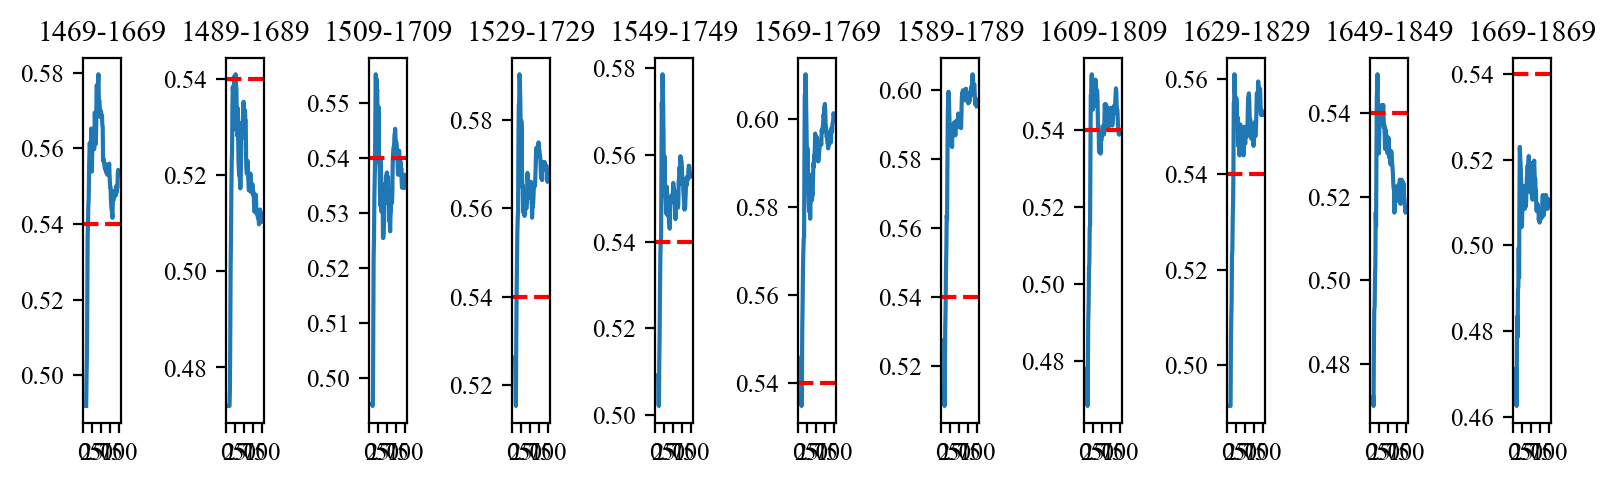

In [10]:
from past1000.compare import compare_corr, compare_corr_2d
from past1000.filters import calc_std_deviation

METHOD = "kendall"
WINDOW_SIZE = 200  # 窗口大小：300年
STEP_SIZE = 20  # 步长：每100年移动一次
DETREND = False
END = 1870

# 创建滑动窗口切片
slice_all = slice(STAGE1, END)
total_range = END - STAGE1
slices = []
slice_labels = []

# 生成所有可能的300年窗口
start_year = STAGE1
while start_year + WINDOW_SIZE <= END:
    end_year = start_year + WINDOW_SIZE
    slices.append(slice(start_year, end_year))
    slice_labels.append(f"{start_year}-{end_year}")
    start_year += STEP_SIZE


windows = np.arange(2, 100)
min_periods = np.repeat(5, 98)

fig, axs = plt.subplots(1, len(slices), figsize=(8, 2.5), tight_layout=True)
axs = axs.flatten()
max_corr = []
max_corr_year = []
mid_year = [np.mean([s.start, s.stop]).astype(int) for s in slices]
# mid_year = [s.stop for s in slices]

for i, slice_now in enumerate(slices):
    ax = axs[i]
    base_corr = compare_corr(
        data1.loc[slice_now],
        data2.loc[slice_now],
        corr_method=METHOD,
    )
    r_benchmark = base_corr[0]
    rs, ps, ns = compare_corr_2d(
        data1=data1.loc[slice_now],
        data2=data2.loc[slice_now],
        windows=windows,
        min_periods=min_periods,
        filter_func=calc_std_deviation,
        corr_method="kendall",
        filter_side=SIDE,
    )
    ax.plot(windows, rs, label=slice_now)
    ax.set_xticks(np.linspace(0, 100, 5))
    ax.axhline(0.54, color="red", ls="--")
    ax.set_title(slice_labels[i])
    top_max_indices = find_top_max_indices(rs, 0.1)
    max_corr_year.append(top_max_indices)
    max_corr.append((rs[top_max_indices] - r_benchmark) / r_benchmark)

plt.show();

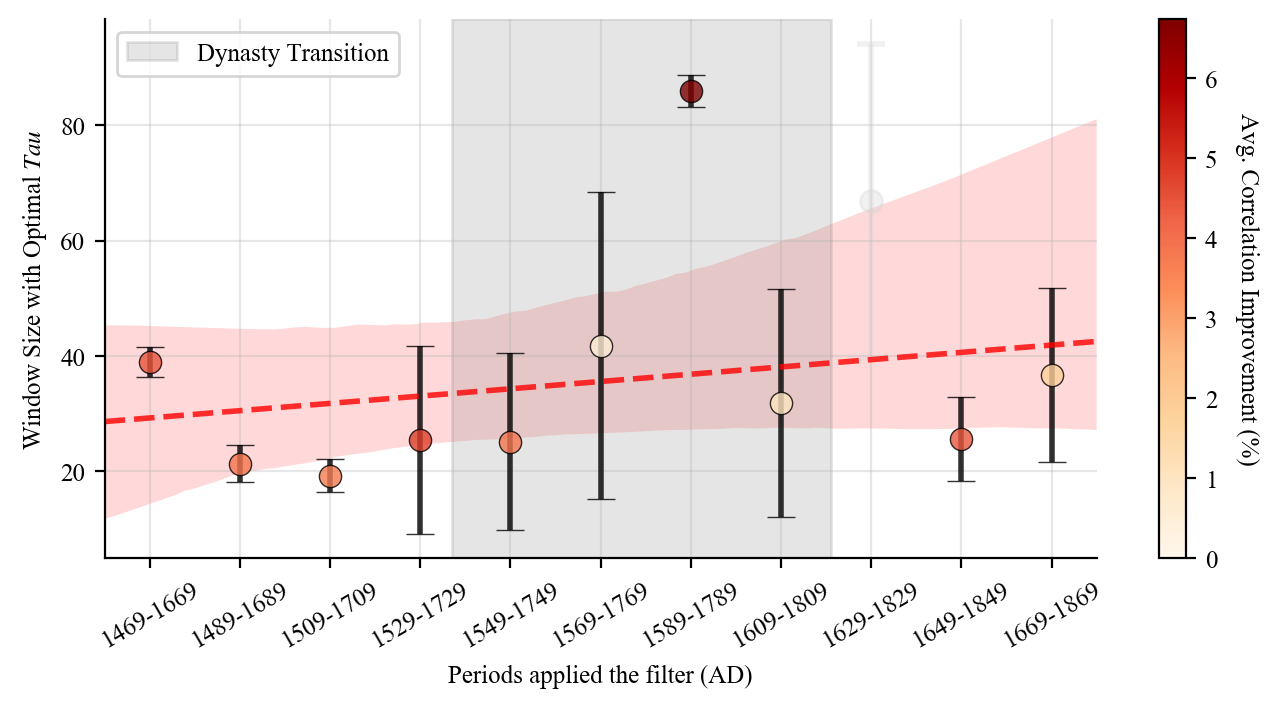

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from matplotkit import with_axes


@with_axes(figsize=(8, 3.5))
def plot_correlation_windows(max_corr_year, max_corr, slice_labels=None, ax=None):
    """
    绘制时间窗口的最优相关性年份图

    Parameters:
    -----------
    max_corr_year : list of arrays
        每个时间窗口的最大相关性年份数据
    max_corr : list of arrays
        每个时间窗口的最大相关性值数据
    slice_labels : list, optional
        时间窗口标签
    figsize : tuple
        图形大小
    """

    # 数据预处理
    means = np.array([arr.mean() for arr in max_corr_year])
    stds = np.array([arr.std() for arr in max_corr_year])

    # 过滤负相关性，转换为改进百分比
    corr_improvements = []
    for arr in max_corr:
        mean_corr = arr.mean()
        corr_improvements.append(mean_corr * 100 if mean_corr >= 0 else np.nan)

    corr_improvements = np.array(corr_improvements)
    valid_mask = ~np.isnan(corr_improvements)

    # 设置颜色映射
    if np.any(valid_mask):
        vmin, vmax = 0, np.nanmax(corr_improvements) + 0.01
        # 确保 vmax > vmin 避免颜色映射问题
        if vmax <= vmin:
            vmax = vmin + 1
    else:
        vmin, vmax = 0, 1

    cmap = cm.OrRd
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # 收集有效点用于趋势线
    valid_points = []

    # 绘制数据点
    i = 0
    for mid, mean_y, std_y, improvement in zip(
        mid_year, means, stds, corr_improvements
    ):
        if valid_mask[i]:
            point_color = cmap(norm(improvement))
            alpha = 0.8
            valid_points.append({"x": mid, "y": mean_y})

            # 绘制带彩色点和黑色误差棒
            ax.errorbar(
                mid,
                mean_y,
                yerr=std_y,
                fmt="o",
                color=point_color,  # 点的颜色
                ecolor="black",  # 误差棒颜色
                elinewidth=2,  # 误差棒线宽
                capsize=5,  # 误差棒端帽大小
                capthick=2,  # 误差棒端帽粗细
                markersize=8,  # 点的大小
                alpha=alpha,
                markeredgecolor="black",  # 点的边框
                markeredgewidth=0.5,  # 点边框宽度
            )
        else:
            # 对于无效数据，可以选择不绘制或用灰色
            ax.errorbar(
                mid,
                mean_y,
                yerr=std_y,
                fmt="o",
                color="lightgray",
                ecolor="lightgray",
                alpha=0.3,
                capsize=5,
                capthick=2,
                elinewidth=2,
                markersize=8,
            )

        i += 1

    # 添加趋势线
    if len(valid_points) > 1:
        valid_df = pd.DataFrame(valid_points)
        sns.regplot(
            data=valid_df,
            x="x",
            y="y",
            scatter=False,
            color="red",
            line_kws={"linewidth": 2, "alpha": 0.8, "linestyle": "--"},
            ax=ax,
            truncate=False,
        )

    # 设置坐标轴
    ax.set_xticks(mid_year)
    ax.set_xticklabels(slice_labels, rotation=30)
    ax.set_xlabel("Periods applied the filter (AD)")
    ax.set_ylabel("Window Size with Optimal $Tau$")
    # ax.set_title("Optimal Year of Max Correlation with Error Bars\n(Color indicates correlation improvement)")
    ax.grid(True, alpha=0.3)

    # 添加颜色条（修复白色问题）
    if np.any(valid_mask):
        # 只为有效数据创建颜色映射
        valid_improvements = corr_improvements[valid_mask]
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(valid_improvements)  # 设置实际数据数组

        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Avg. Correlation Improvement (%)", rotation=270, labelpad=15)

    return ax


# 使用函数
ax = plot_correlation_windows(max_corr_year, max_corr, slice_labels)
lims = ax.get_xlim()
ax.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")
ax.set_xlim(lims)
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show();

### 综合作图

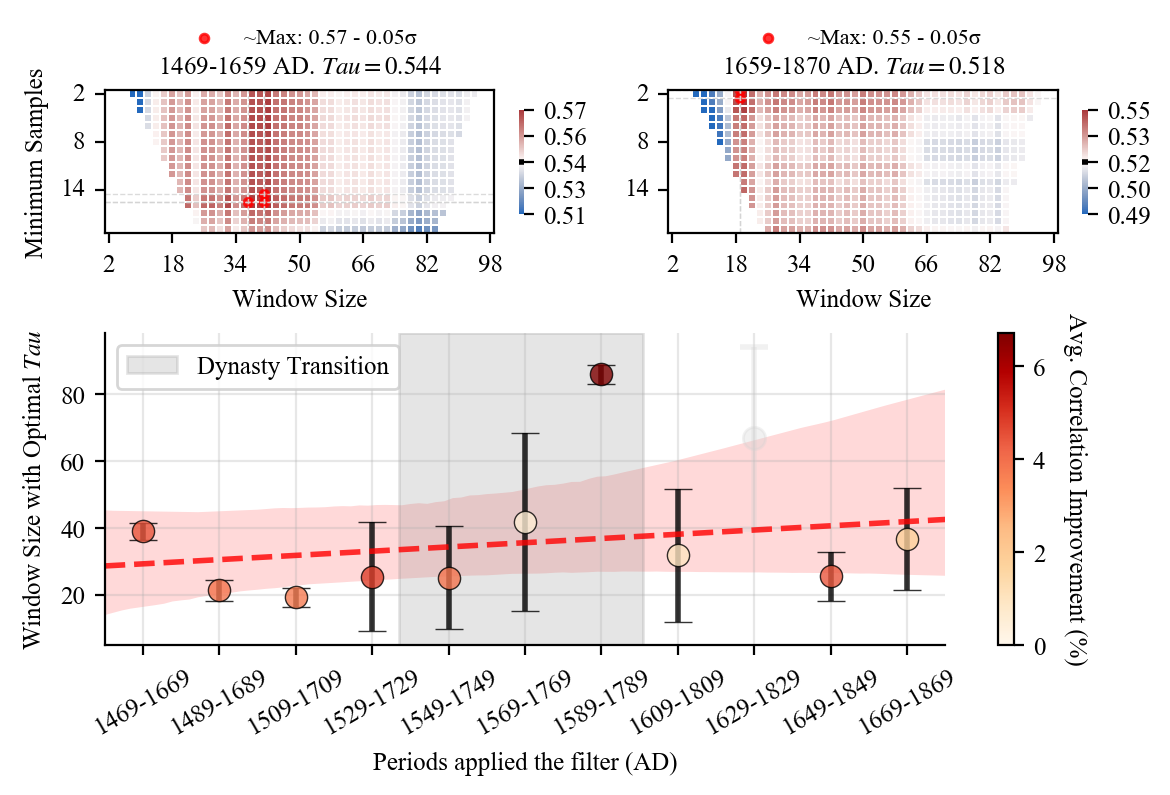

In [17]:
fig = plt.figure(figsize=(6, 4), constrained_layout=False)  # 增加高度

gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[1, 1.2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# 四次对比实验
for i, slice_now in enumerate([slice1, slice2]):
    ax = [ax1, ax2][i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=METHOD,
        filter_func=calc_std_deviation,
        filter_side=SIDE,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.05,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # x轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)


# 绘制不同历史时期的窗口图
# 使用函数
ax3 = plot_correlation_windows(max_corr_year, max_corr, slice_labels, ax=ax3)
lims = ax3.get_xlim()
ax3.axvspan(1636, 1700, color="gray", alpha=0.2, label="Dynasty Transition")
ax3.set_xlim(*lims)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.legend()

ax2.set_ylabel("")
plt.tight_layout()
plt.show();